# **Web Scraping**
#### Title: **Housing Market (www.PAP.fr)**

##### Author: **`Bilal KACEL`**
##### Version: 1.0.0

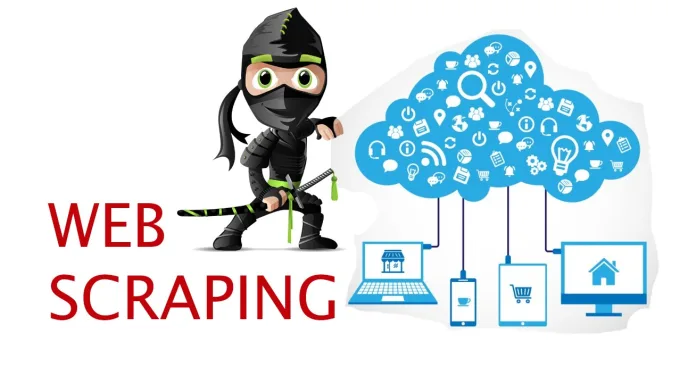

# **PART 1**: Lab Assignment

In this lab assignment, you will improve your skills in scraping data from web pages, organizing the data in a desired format. To do so, we will use data that is provided by the Indeed company via their web pages.

Let us start with importing of the relevant packages.

Warning: I am using Python 3 for this lab assignment. If you are using Python 2, then some libraries may need to be changed., e.g., urllib -> urlib2.

In [ ]:
# -*- coding: utf-8 -*- 

In [ ]:
import urllib.request
import urllib.error
import bs4 #this is beautiful soup

import time
from pandas import Series
import pandas as pd
from pandas import DataFrame
import numpy as np
import re

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

As you see, you imported the package called `re`, which supports regular expression operations. You have already used the other packages. 

The following block will access and load the contents of an Indeed.com web page. It will probably give you a warning -- please ignore it.

In [ ]:
# Fixed url for job postings containing data scientist
url = 'https://www.indeed.fr/jobs?q=data+scientist&l=%C3%8Ele-de-France'

# read the website
source = urllib.request.urlopen(url).read().decode('utf-8')

# parse html code
bs_tree = bs4.BeautifulSoup(source)

In [ ]:
# see how many job postings we found
job_count_string = bs_tree.find(id = 'searchCountPages').contents[0] # Get the tag content
job_count_string = job_count_string.split()[-2] # Result of the split: ['Page', '1', 'de', '858', 'emplois']
# the index -2 get the penultimate element, the number of result pages according to the query

print(("Search yielded %s hits." % (job_count_string)))

# not that job_count so far is still a string, 
# not an integer, and the , separator prevents 
# us from just casting it to int

job_count_digits = [int(d) for d in job_count_string if d.isdigit()]
job_count_digits

Search yielded 861 hits.


[8, 6, 1]

In [ ]:
# see how many job postings we found
job_count_string = bs_tree.find(id = 'searchCountPages').contents[0] # Get the tag content
job_count_string = job_count_string.split()[-2] # Result of the split: ['Page', '1', 'de', '858', 'emplois']
# the index -2 get the penultimate element, the number of result pages according to the query

print(("Search yielded %s hits." % (job_count_string)))

# not that job_count so far is still a string, 
# not an integer, and the , separator prevents 
# us from just casting it to int

job_count_digits = [int(d) for d in job_count_string if d.isdigit()]
job_count = np.sum([digit*(10**exponent) for digit, exponent in 
                    zip(job_count_digits[::-1], list(range(len(job_count_digits))))])

print(job_count)

Search yielded 861 hits.
861


In [ ]:
# Get the Salary Estimate jobs
span_tag = bs_tree.select('span.salaryText')
salary_estimate = []
for tag in span_tag:
    salary_estimate.append(
        tag.text.replace('\xa0', '')
        .replace(' par an', '')
        .strip())

print(salary_estimate)

['40000 € - 60000 €', '38718 € - 57180 €', '1000 € - 1001 € par mois']


The following piece of code allows you to find the links to all the job ads on the page.

In [ ]:
# The website is only listing 10 results per page, 
# so we need to scrape them page after page
num_pages = int(np.ceil(job_count/10.0))

base_url = 'http://www.indeed.com' # root URL
job_links = [] # list of job links

for i in range(1): #do range(num_pages) if you want them all
    
    # browse jobs by batch of 10 = 1 result page
    url = 'https://www.indeed.fr/emplois?q=data+scientist&l=%C3%8Ele-de-France&start=' + str(i*10)
    
    print(url)
    
    html_page = urllib.request.urlopen(url).read().decode('utf-8')
    bs_tree = bs4.BeautifulSoup(html_page) # Get the whole HTML page code
    
    job_link_area = bs_tree.find(id = 'resultsCol') # Filter on the tag with id='resultsCol'
    job_postings = job_link_area.findAll("div") # From the previous result, get the list of all sections (all div tags)

    #print(job_postings)
    
    # Filter only on all job postings sections where there is 'row result' key words in the class name
    job_postings = [jp for jp in job_postings if str(jp.get('class')).find('row result')]
    
    # Get the job ads IDs 
    job_ids = [jp.get('data-jk') for jp in job_postings]
    
    # go after each link
    for id in job_ids:
        if (id != None):
            job_links.append(base_url + '/rc/clk?jk=' + id)
            
    # job_links gets all URLs to go through the web site of the company that recruits
    
    time.sleep(1)

print("We found a lot of jobs: ", len(job_links))

i = 1
for job in job_links[:5]:
    print("Job link", i, ":", job)
    i += 1

https://www.indeed.fr/emplois?q=data+scientist&l=%C3%8Ele-de-France&start=0
We found a lot of jobs:  10
Job link 1 : http://www.indeed.com/rc/clk?jk=12dd42e5be0280ca
Job link 2 : http://www.indeed.com/rc/clk?jk=f28298d935d8b9b8
Job link 3 : http://www.indeed.com/rc/clk?jk=7517068052548eb1
Job link 4 : http://www.indeed.com/rc/clk?jk=58610934ab5e2312
Job link 5 : http://www.indeed.com/rc/clk?jk=3c3014c50aabee93


In [ ]:
# The website is only listing 10 results per page, 
# so we need to scrape them page after page
num_pages = int(np.ceil(job_count/10.0))

base_url = 'http://www.indeed.com' # root URL
job_links_200 = [] # list of job links

max_job_links = 200
max_job_links_reached = False

for i in range(num_pages): #do range(num_pages) if you want them all
    
    # browse jobs by batch of 10 = 1 result page
    url = 'https://www.indeed.fr/jobs?q=data+science&l=%C3%8Ele-de-France&start=' + str(i*10)
    
    print(url)
    
    html_page = urllib.request.urlopen(url).read().decode('utf-8')
    bs_tree = bs4.BeautifulSoup(html_page) # Get the whole HTML page code
    
    job_link_area = bs_tree.find(id = 'resultsCol') # Filter on the tag with id='resultsCol'
    job_postings = job_link_area.findAll("div") # From the previous result, get the list of all sections (all div tags)

    #print(job_postings)
    
    # Filter only on all job postings sections where there is 'row result' key words in the class name
    job_postings = [jp for jp in job_postings if str(jp.get('class')).find('row result')]
    
    # Get the job ads IDs 
    job_ids = [jp.get('data-jk') for jp in job_postings]
    
    # go after each link
    for id in job_ids:
        if (id != None):
            job_links_200.append(base_url + '/rc/clk?jk=' + id)

        # Stop the loop when the max job links is reached
        if len(job_links_200) >= max_job_links:
            max_job_links_reached = True
            break
    
    # Stop the loop when the max job links is reached
    if len(job_links_200) >= max_job_links:
        max_job_links_reached = True
        break
            
    # job_links_200 gets all URLs to go through the web site of the company that recruits
    
    time.sleep(1)

print("We found a lot of jobs: ", len(job_links_200))

i = 1
for job in job_links_200[:]:
    print("Job "+ str(i) +":\t\t", job)
    i += 1

https://www.indeed.fr/jobs?q=data+science&l=%C3%8Ele-de-France&start=0
https://www.indeed.fr/jobs?q=data+science&l=%C3%8Ele-de-France&start=10
https://www.indeed.fr/jobs?q=data+science&l=%C3%8Ele-de-France&start=20
https://www.indeed.fr/jobs?q=data+science&l=%C3%8Ele-de-France&start=30
https://www.indeed.fr/jobs?q=data+science&l=%C3%8Ele-de-France&start=40
https://www.indeed.fr/jobs?q=data+science&l=%C3%8Ele-de-France&start=50
https://www.indeed.fr/jobs?q=data+science&l=%C3%8Ele-de-France&start=60
https://www.indeed.fr/jobs?q=data+science&l=%C3%8Ele-de-France&start=70
https://www.indeed.fr/jobs?q=data+science&l=%C3%8Ele-de-France&start=80
https://www.indeed.fr/jobs?q=data+science&l=%C3%8Ele-de-France&start=90
https://www.indeed.fr/jobs?q=data+science&l=%C3%8Ele-de-France&start=100
https://www.indeed.fr/jobs?q=data+science&l=%C3%8Ele-de-France&start=110
https://www.indeed.fr/jobs?q=data+science&l=%C3%8Ele-de-France&start=120
https://www.indeed.fr/jobs?q=data+science&l=%C3%8Ele-de-France

The following piece of code accesses and grabs the content of all ads in the `job_links` and extracts all the human-readable text tokens. Then, it counts on how many pages are words `hadoop`, `spark`, and `python` used. It might take a few seconds to execute.

In [ ]:
skill_set = {'hadoop':0, 'spark':0, 'python':0}
counter = 0
for link in job_links:
    counter +=1  
    
    print(link)
    
    try:
        html_page = urllib.request.urlopen(link).read()
    except urllib.error.HTTPError:
        continue
    except urllib.error.URLError:
        continue
    except socket.error as error:
        print("Connection closed")
        continue
    
    try:
        html_text = re.sub("[^a-z.+3]"," ", html_page.decode('utf-8').lower()) # replace all but the listed characters
        #html_text = re.sub("[^a-z.+3]"," ", html_page.lower()) # replace all but the listed characters
    
    except UnicodeDecodeError:
        print("UnicodeDecodeError ...")
        

    for key in list(skill_set.keys()):
        if key in html_text:  
            skill_set[key] +=1

    if counter % 5 == 0:
        print(len(job_links) - counter)
        print(skill_set)

print(skill_set)

http://www.indeed.com/rc/clk?jk=12dd42e5be0280ca
http://www.indeed.com/rc/clk?jk=f28298d935d8b9b8
http://www.indeed.com/rc/clk?jk=7517068052548eb1
http://www.indeed.com/rc/clk?jk=58610934ab5e2312
http://www.indeed.com/rc/clk?jk=3c3014c50aabee93
5
{'hadoop': 0, 'spark': 1, 'python': 4}
http://www.indeed.com/rc/clk?jk=5ad2fecabc582d63
http://www.indeed.com/rc/clk?jk=cd480dae0ba87b97
http://www.indeed.com/rc/clk?jk=7a2e790775541b32
http://www.indeed.com/rc/clk?jk=e22c9249f1a6afd7
http://www.indeed.com/rc/clk?jk=5e87dddf752697b6
0
{'hadoop': 1, 'spark': 3, 'python': 9}
{'hadoop': 1, 'spark': 3, 'python': 9}


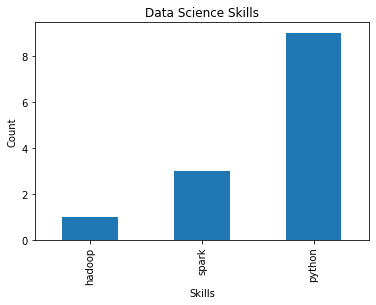

In [ ]:
pseries = pd.Series(skill_set)
pseries.sort_values(ascending=False)

pseries.plot(kind = 'bar')
## set the title to Score Comparison
plt.title('Data Science Skills')
## set the x label
plt.xlabel('Skills')
## set the y label
plt.ylabel('Count')
## show the plot
plt.show()

In [ ]:
skill_set_200 = {'hadoop':0, 'spark':0, 'python':0}
counter = 0
for link in job_links_200:
    counter +=1  

    #print(link)
    
    try:
        html_page = urllib.request.urlopen(link).read()
    except urllib.error.HTTPError:
        continue
    except urllib.error.URLError:
        continue
    except socket.error as error:
        print("Connection closed")
        continue
    
    try:
        html_text = re.sub("[^a-z.+3]"," ", html_page.decode('utf-8').lower()) # replace all but the listed characters
        #html_text = re.sub("[^a-z.+3]"," ", html_page.lower()) # replace all but the listed characters
    
    except UnicodeDecodeError:
        #print("UnicodeDecodeError ...")
        continue
    
    
    for key in list(skill_set_200.keys()):
        if key in html_text:  
            skill_set_200[key] +=1

    if counter % 10 == 0:
        print(len(job_links_200) - counter, "pages remaining ...  >>> Current picture: ", skill_set_200)
        #print(skill_set_200)

print("Final result: ", skill_set_200)

190 pages remaining ...  >>> Current picture:  {'hadoop': 0, 'spark': 1, 'python': 8}
180 pages remaining ...  >>> Current picture:  {'hadoop': 3, 'spark': 5, 'python': 15}
170 pages remaining ...  >>> Current picture:  {'hadoop': 4, 'spark': 7, 'python': 20}
160 pages remaining ...  >>> Current picture:  {'hadoop': 5, 'spark': 7, 'python': 28}
150 pages remaining ...  >>> Current picture:  {'hadoop': 5, 'spark': 8, 'python': 35}
140 pages remaining ...  >>> Current picture:  {'hadoop': 6, 'spark': 8, 'python': 42}
130 pages remaining ...  >>> Current picture:  {'hadoop': 10, 'spark': 8, 'python': 50}
120 pages remaining ...  >>> Current picture:  {'hadoop': 12, 'spark': 9, 'python': 58}
110 pages remaining ...  >>> Current picture:  {'hadoop': 13, 'spark': 9, 'python': 62}
100 pages remaining ...  >>> Current picture:  {'hadoop': 14, 'spark': 11, 'python': 68}
90 pages remaining ...  >>> Current picture:  {'hadoop': 16, 'spark': 12, 'python': 74}
80 pages remaining ...  >>> Current pi

In [ ]:
pseries = pd.Series(skill_set_200)
pseries.sort_values(ascending=False)

pseries.plot(kind = 'bar')
## set the title to Score Comparison
plt.title('Data Science Skills')
## set the x label
plt.xlabel('Skills')
## set the y label
plt.ylabel('Count')
## show the plot
plt.show()

# **PART 2**: Data analysis of the housing market in the Paris area (*`www.PAP.fr`*)

In the first part of the lab, you created `skill_set` dictionary that counts occurences of 3 important data science skills of the jobs in Ile de France. In the second part of this lab, your task will be to create a pandas 'DataFrame' object containing information about the flats/houses that are available for rent in the paris area. For each offer, you will have to create columns such as: 
- Location
- Surface
- Number of rooms
- ...

To do so, we will be using seloger.com. Unlike the first part, where you were provided with snippets of codes that help you get familiarized with Web Scrapping skills, in this part you are left on your own to figure out how to do so. You can reduce your search to a specific area of paris, e.g., Paris 9, and for specific range of rent [700 euros,800 euros].

https://www.seloger.com/list.htm?projects=1&types=1,2&places=[{div:2238}]&price=700/800&enterprise=0&qsVersion=1.0

Note: I obtained the above URL by simply using the web page as a human via a browser, and specifying the criteria I needed to via the web form provided by seloger.com


**Remark**: **as proposed and according to the agent issue with seLoger.com website, we adviced us to scan another website like:** **`www.PAP.fr`**

## **1) Import Dependencies**

In [ ]:
# -*- coding: utf-8 -*-
"""
Script to retrieve data from the site seloger.com
"""

import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns

# working_dir = "C:/Users/Bilal/Documents/Python Scripts/seloger_scraper"
# os.chdir(working_dir)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## **2) Some preparations**

In [ ]:
# Initialize variables
locality = []
price = []
room_nb = []
bedroom_nb = []
surface = []
#acc_type = []
url_annonce = []
description = []


# Create a session (to avoid redirecting loop with requests.get())
s = requests.Session()
s.headers['User-Agent'] = 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_2) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/34.0.1847.131 Safari/537.36'

## **3) Scan announcements**

In [ ]:
# Loop over different pages
max_pages = 10
page = 1
nb_annonces = 0

while (page <= max_pages):
    url = ("https://www.pap.fr/proximite/location-appartement-maison-paris-9e-g37776-jusqu-a-800-euros-" + str(page))
    
    print("URL", page,": \t", url)

    page += 1
    try:
        r = s.get(url)
    except:
        # Stop visiting pages
        break
    
    # Get information from the page
    soup = BeautifulSoup(r.text, 'html.parser')
    
    # find all ads from the page
    annonces = soup.find_all("div", attrs={"class": "item-body"})

    for annonce in annonces:
        
        url_annonce.append("https://www.pap.fr" + annonce.find("a", attrs={"class": "item-title"})["href"])


        # get properties of the appartment/house
        # DESCRIPTION
        description.append(annonce.find("p", attrs={"class": "item-description"}).get_text())

        # LOCALITY
        curr_locality = annonce.find("span", attrs={"class": "h1"}).get_text()
        locality.append(curr_locality)

        # PRICE
        curr_price = annonce.find("span", attrs={"class": "item-price"}).get_text().replace('\xa0€', '')
        price.append(float(curr_price))

        # PROPERTY LIST
        property_list = annonce.find("ul", attrs={"class": "item-tags"}).find_all("li")
        
        curr_room_nb = ""
        curr_bedroom_nb = ""
        curr_surface = ""

        # Management of the property list number
        if (len(property_list) == 3):
            curr_room_nb = property_list[0].get_text()

            # Singular or plural management
            if curr_room_nb.count('pièces') > 0:
              room_nb.append(int(curr_room_nb.replace('pièces', '').strip()))
            elif curr_room_nb.count('pièce') > 0:
              room_nb.append(int(curr_room_nb.replace('pièce', '').strip()))

            curr_bedroom_nb = property_list[1].get_text()

            # Singular or plural management
            if curr_bedroom_nb.count('chambres') > 0:
              bedroom_nb.append(int(curr_bedroom_nb.replace('chambres', '').strip()))
            elif curr_bedroom_nb.count('chambre') > 0:
              bedroom_nb.append(int(curr_bedroom_nb.replace('chambre', '').strip()))


            curr_surface = property_list[2].get_text().replace('m2', '')
            surface.append(float(curr_surface))


        elif (len(property_list) == 2):
            curr_room_nb = property_list[0].get_text()

            # Singular or plural management
            if curr_room_nb.count('pièces') > 0:
              room_nb.append(int(curr_room_nb.replace('pièces', '').strip()))
            elif curr_room_nb.count('pièce') > 0:
              room_nb.append(int(curr_room_nb.replace('pièce', '').strip()))


            if property_list[1].get_text().count("chambre") > 0:
  
              curr_bedroom_nb = property_list[1].get_text()

              if curr_bedroom_nb.count('chambres') > 0:
                bedroom_nb.append(int(curr_bedroom_nb.replace('chambres', '').strip()))
              elif curr_bedroom_nb.count('chambre') > 0:
                bedroom_nb.append(int(curr_bedroom_nb.replace('chambre', '').strip()))

              surface.append(np.nan)


            else:
              # Surface without bedroom number
              bedroom_nb.append(np.nan)

              curr_surface = property_list[1].get_text().replace('m2', '')

              surface.append(float(curr_surface))

        else:
            room_nb.append("")
            bedroom_nb.append("")
            surface.append("")

        nb_annonces += 1


print("================================================================")
print("Nombre de Pages=", page, "\t Nombre Total d'Annonces=", nb_annonces)

URL 1 : 	 https://www.pap.fr/proximite/location-appartement-maison-paris-9e-g37776-jusqu-a-800-euros-1
URL 2 : 	 https://www.pap.fr/proximite/location-appartement-maison-paris-9e-g37776-jusqu-a-800-euros-2
URL 3 : 	 https://www.pap.fr/proximite/location-appartement-maison-paris-9e-g37776-jusqu-a-800-euros-3
URL 4 : 	 https://www.pap.fr/proximite/location-appartement-maison-paris-9e-g37776-jusqu-a-800-euros-4
URL 5 : 	 https://www.pap.fr/proximite/location-appartement-maison-paris-9e-g37776-jusqu-a-800-euros-5
URL 6 : 	 https://www.pap.fr/proximite/location-appartement-maison-paris-9e-g37776-jusqu-a-800-euros-6
URL 7 : 	 https://www.pap.fr/proximite/location-appartement-maison-paris-9e-g37776-jusqu-a-800-euros-7
URL 8 : 	 https://www.pap.fr/proximite/location-appartement-maison-paris-9e-g37776-jusqu-a-800-euros-8
URL 9 : 	 https://www.pap.fr/proximite/location-appartement-maison-paris-9e-g37776-jusqu-a-800-euros-9
URL 10 : 	 https://www.pap.fr/proximite/location-appartement-maison-paris

## **4) Data Format inside a DataFrame + Data cleaning**

In [ ]:
# Dataframe containing the whole data scraped from PAP.fr
rst = pd.DataFrame({"locality": locality,
                    "price": price,
                    "room_nb": room_nb,
                    "bedroom_nb": bedroom_nb,
                    "surface": surface,
                    "url_annonce": url_annonce,
                    "description": description
                    })

rst

,locality,price,room_nb,bedroom_nb,surface,url_annonce,description
0,Paris 9E (75009),750.0,1,NaN,12.0,https://www.pap.fr/annonces/appartement-paris-...,\n\t\t\t\t\tProximité rue des Martyrs - Locati...
1,Paris 9E,690.0,1,NaN,9.0,https://www.pap.fr/annonces/appartement-paris-...,"\n\t\t\t\t\tCommerces et transports, quartier ..."
2,Paris 9E (75009),770.0,1,NaN,15.0,https://www.pap.fr/annonces/appartement-paris-...,"\n\t\t\t\t\tMétro Notre Dame de Lorette, rue S..."
3,Paris 9E (75009),780.0,1,NaN,18.0,https://www.pap.fr/annonces/appartement-paris-...,\n\t\t\t\t\tQuartier Rochechouart / Martyrs / ...
4,Paris,640.0,1,1.0,15.0,https://www.pap.fr/annonces/appartement-paris-...,"\n\t\t\t\t\tRER Auber Opera, métro Chaussée d'..."
...,...,...,...,...,...,...,...
145,Paris 4E,800.0,1,NaN,16.0,https://www.pap.fr/annonces/appartement-paris-...,\n\t\t\t\t\tRue Pecquay.\r\n\r\nStudio meublé ...
146,Paris 4E (75004),600.0,1,NaN,9.0,https://www.pap.fr/annonces/appartement-paris-...,"\n\t\t\t\t\t**Beau studio, 9m²**, rue des Rosi..."
147,Paris 4E,600.0,1,NaN,12.0,https://www.pap.fr/annonces/appartement-paris-...,\n\t\t\t\t\tSully-Morland studette de 12m2 dan...
148,Paris 18E,700.0,1,NaN,14.0,https://www.pap.fr/annonces/appartement-paris-...,"\n\t\t\t\t\tPetit studio rénové/studette, 14 m..."


In [ ]:
# Remove duplicate announcements
rst = rst.drop_duplicates()
rst

,locality,price,room_nb,bedroom_nb,surface,url_annonce,description
0,Paris 9E (75009),750.0,1,NaN,12.0,https://www.pap.fr/annonces/appartement-paris-...,\n\t\t\t\t\tProximité rue des Martyrs - Locati...
1,Paris 9E,690.0,1,NaN,9.0,https://www.pap.fr/annonces/appartement-paris-...,"\n\t\t\t\t\tCommerces et transports, quartier ..."
2,Paris 9E (75009),770.0,1,NaN,15.0,https://www.pap.fr/annonces/appartement-paris-...,"\n\t\t\t\t\tMétro Notre Dame de Lorette, rue S..."
3,Paris 9E (75009),780.0,1,NaN,18.0,https://www.pap.fr/annonces/appartement-paris-...,\n\t\t\t\t\tQuartier Rochechouart / Martyrs / ...
4,Paris,640.0,1,1.0,15.0,https://www.pap.fr/annonces/appartement-paris-...,"\n\t\t\t\t\tRER Auber Opera, métro Chaussée d'..."
...,...,...,...,...,...,...,...
145,Paris 4E,800.0,1,NaN,16.0,https://www.pap.fr/annonces/appartement-paris-...,\n\t\t\t\t\tRue Pecquay.\r\n\r\nStudio meublé ...
146,Paris 4E (75004),600.0,1,NaN,9.0,https://www.pap.fr/annonces/appartement-paris-...,"\n\t\t\t\t\t**Beau studio, 9m²**, rue des Rosi..."
147,Paris 4E,600.0,1,NaN,12.0,https://www.pap.fr/annonces/appartement-paris-...,\n\t\t\t\t\tSully-Morland studette de 12m2 dan...
148,Paris 18E,700.0,1,NaN,14.0,https://www.pap.fr/annonces/appartement-paris-...,"\n\t\t\t\t\tPetit studio rénové/studette, 14 m..."


In [ ]:
# Cast some columns into Float type
rst["price"] = pd.to_numeric(rst["price"], downcast="float")
rst["room_nb"] = pd.to_numeric(rst["room_nb"], downcast="float")
rst["bedroom_nb"] = pd.to_numeric(rst["bedroom_nb"], downcast="float")
rst["surface"] = pd.to_numeric(rst["surface"], downcast="float")

In [ ]:
# Get statistical information about the numerical data
rst.describe()

,price,room_nb,bedroom_nb,surface
count,150.000000,150.000000,41.0,148.000000
mean,695.393311,1.080000,1.0,14.060811
std,99.117500,0.272202,0.0,3.653768
min,420.000000,1.000000,1.0,9.000000
25%,630.000000,1.000000,1.0,11.000000
50%,699.500000,1.000000,1.0,14.000000
75%,770.000000,1.000000,1.0,16.000000
max,880.000000,2.000000,1.0,25.000000


In [ ]:
# Strategy to fill NaN data

#rst.fillna(rst.mean(), inplace=True)
rst.fillna(method='ffill', inplace=True)

In [ ]:
# Check the global data information after filling NaN data
rst.describe()

,price,room_nb,bedroom_nb,surface
count,150.000000,150.000000,146.0,150.000000
mean,695.393311,1.080000,1.0,14.053333
std,99.117500,0.272202,0.0,3.641274
min,420.000000,1.000000,1.0,9.000000
25%,630.000000,1.000000,1.0,11.000000
50%,699.500000,1.000000,1.0,14.000000
75%,770.000000,1.000000,1.0,16.000000
max,880.000000,2.000000,1.0,25.000000


In [ ]:
# Example: Create a new indicator
rst["price_m2"] = rst["price"]/rst["surface"]

## **5) Data Visualization examples**

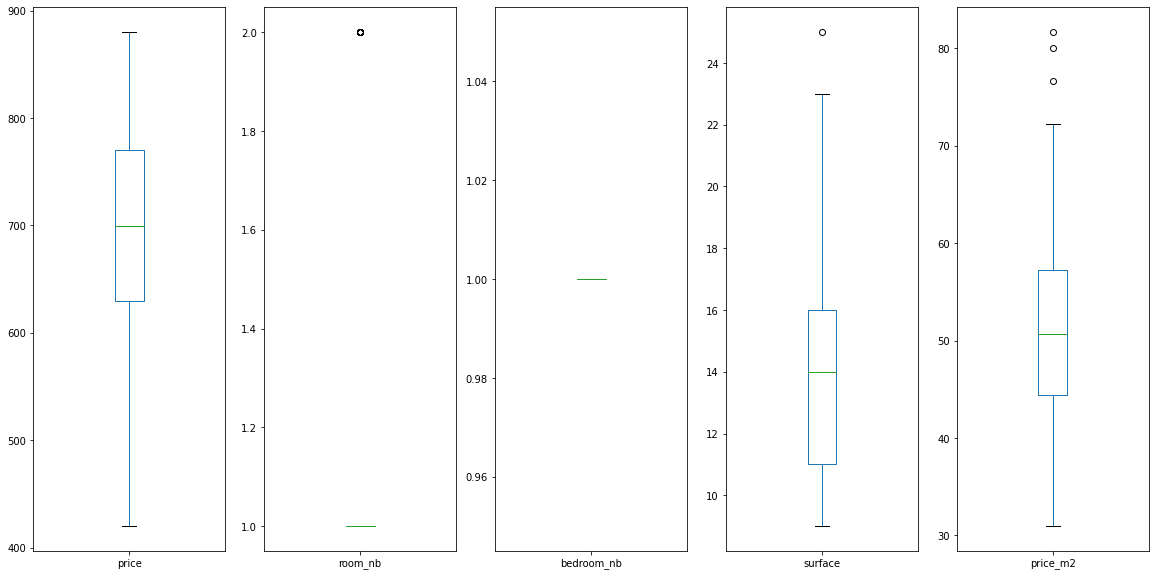

In [ ]:
rst.plot(kind="box", subplots=True, figsize=(20,10))
plt.show()

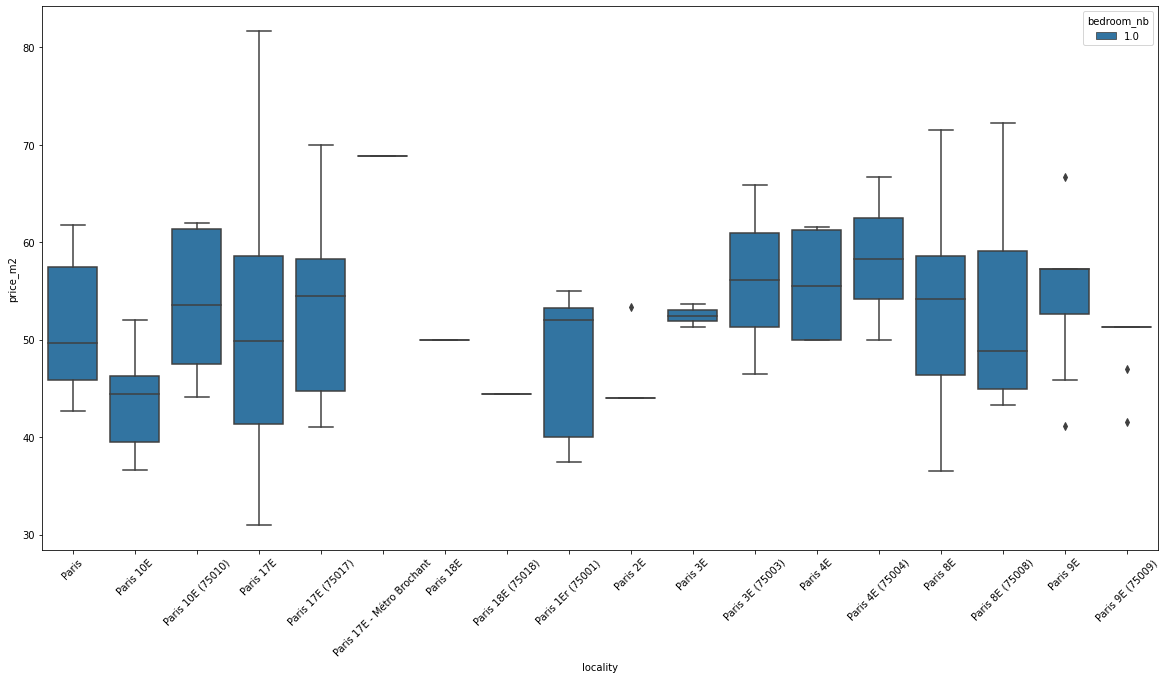

<Figure size 432x288 with 0 Axes>

In [ ]:
min(rst.price_m2)
rst["locality"].unique()

localities = rst.locality.unique()
#localities.sort()
#rst["locality"] = rst["locality"].astype("category", categories=localities)
rst["locality"] = rst["locality"].astype("category")


plt.figure(figsize=(20, 10))
sns.boxplot(data=rst, x="locality", y="price_m2", hue="bedroom_nb")
plt.xticks(rotation=45)
plt.show()
sns.despine(offset=10, trim=True)

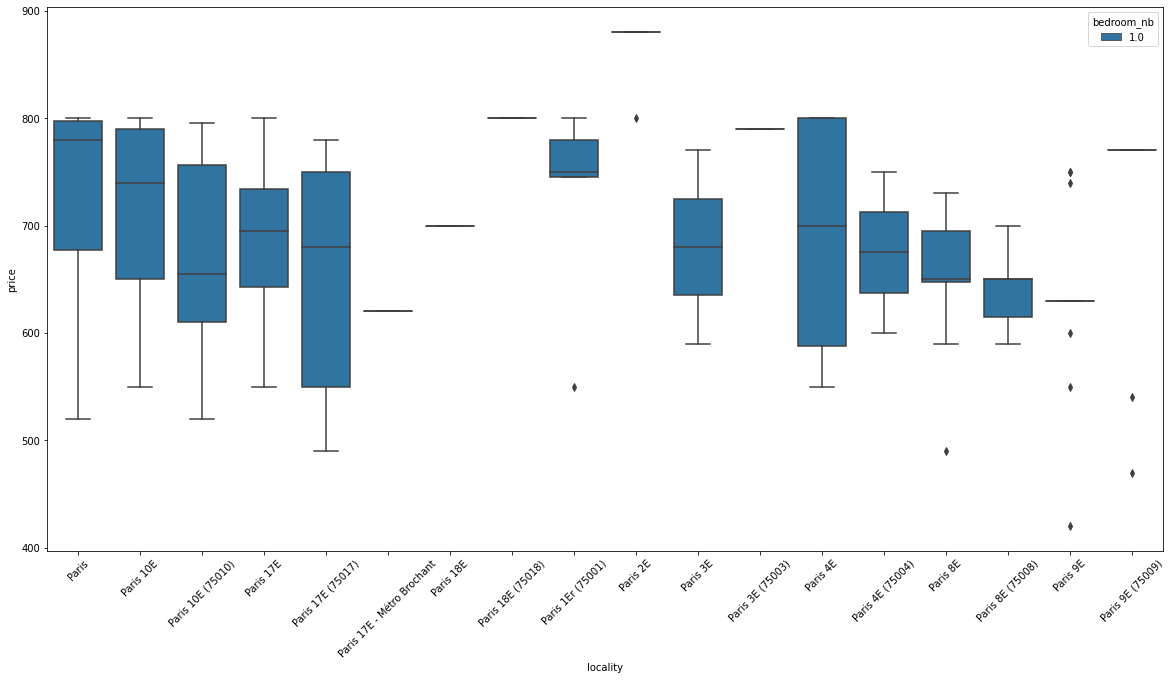

In [ ]:
plt.figure(figsize=(20, 10))
sns.boxplot(data=rst, x="locality", y="price", hue="bedroom_nb")
plt.xticks(rotation=45)
plt.show()

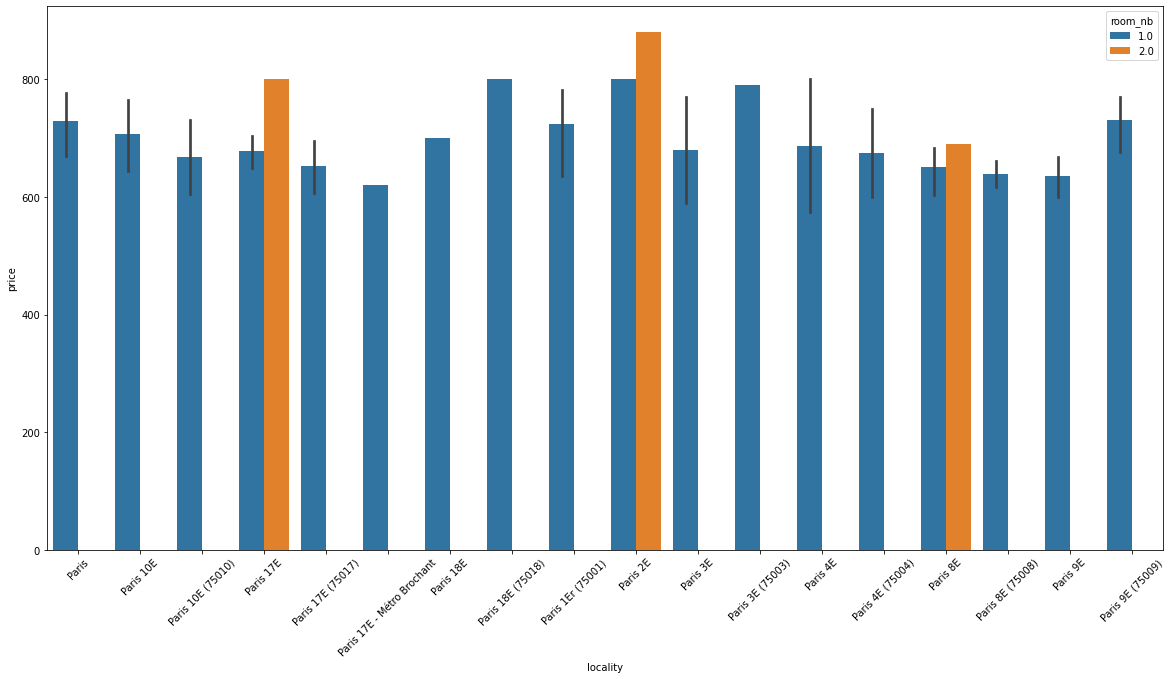

In [ ]:
plt.figure(figsize=(20, 10))
sns.barplot(data=rst, x="locality", y="price", hue="room_nb")
plt.xticks(rotation=45)
plt.show()

In [ ]:
from IPython.display import Image
Image(url='https://i.pinimg.com/originals/c4/23/fe/c423fe4225af7ae2e06879b117b41115.gif')